# Part II - Ford GoBike System Analysis
## by Oluwatobi Ajao

## Investigation Overview
The dataset includes a February 2019 information about individual rides made in a bike-sharing system covering the greater San Francisco Bay area. Details such as the total duration of each subscriber's (or customer's) trip is located alongside the location where the trip started and where the trip ended.
I have the aim of knowing the demographics of the bike riders; their age group and gender.
I would also ike to the time of the day they mostly make rides and how long the riders by their age, gender, subscription status and hour of the day.


## Dataset Overview

The dataset has 183215 bike trips and 19 fields describing each field. The trips that span over 36 thousand hours were done in 329 stations. The columns are mostly float and string, except the duration_sec which is understandably integer

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype
import datetime as dt
pd.options.mode.chained_assignment = None  # default='warn'

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# import and load the dataset into a DataFrame
df = pd.read_csv('fordgobike.csv')

In [3]:
df['member_birth_year'].fillna(0, inplace = True)
df['member_gender'].fillna('Other', inplace = True)
# Add an additional column for age of members
# This will later help in understanding the age distribution of respondents
df['member_age'] = 2019 - df[df['member_birth_year'] != 0]['member_birth_year']
# Fill null values, and convert column data type to int
df['member_age'].fillna(0, inplace = True)
df['member_age'] = df['member_age'].astype(int)
# Add an additional column for duration in minutes
df['duration_mins'] = df['duration_sec']/60
# Fill null values, and convert column data type to int
df['member_age'].fillna(0, inplace = True)
df['member_age'] = df['member_age'].astype(int)

In [4]:
# Convert 'start_time' to datetime data type
df['start_time'] = pd.to_datetime(df['start_time'].str[:19], format='%Y-%m-%d %H:%M:%S')

# Add an additional column for 'start_hour'
df['start_hour'] = df['start_time'].dt.strftime('%H')

# Order the start_hour
order_hour = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12',
         '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '00']

# Define a caterogical data type
order_hour_cat = CategoricalDtype(categories=order_hour, ordered=True)

# Set the 'start_hour' data type to the defined data type
df['start_hour'] = df['start_hour'].astype(order_hour_cat)

In [5]:
df = df[df['start_station_id'].notnull()]

# convert 'start_station_id', 'end_station_id' and 'bike_id' columns to string datatype
ids = ['start_station_id', 'end_station_id', 'bike_id']

for typ in ids:
    df[typ] = df[typ].astype(str)

## Gender Distribution of the dataset
Plotting the Gender, Male vs Female to show which gender has the majority of the customers/subscribers


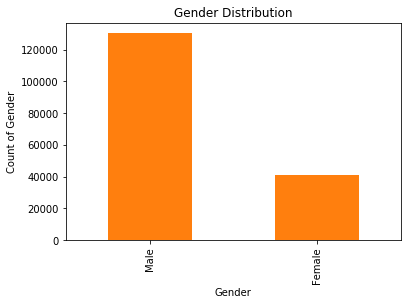

In [6]:
gender_df = df[df['member_gender'].isin(['Male', 'Female'])]
gender = gender_df['member_gender'].value_counts()
gender.plot(kind = "bar", color=sns.color_palette()[1]);

plt.title("Gender Distribution")
plt.ylabel('Count of Gender')
plt.xlabel('Gender');

## Age distribution of riders
In exploring the age distribution of the bike riders, the seaborn violin plot and the histogram will be used.
As the chart visualizations below shows, it is not surprising that the riders are mostly young people between the ages of 20 and 40 years

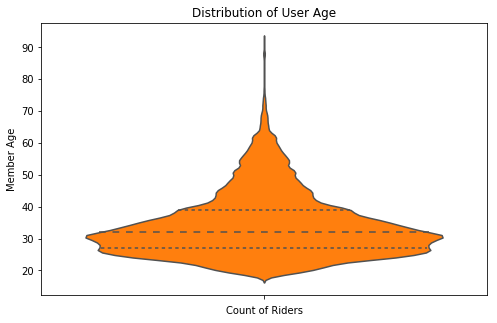

In [11]:
# Investigate User Age distribution
df_age = df[df['member_age'] != 0]
df_age = df_age[df_age['member_age'] <= 95]
plt.figure(figsize=(8, 5))
sns.violinplot(df_age.member_age, inner='quartile', orient='v', saturation=1.5, color=sns.color_palette()[1])
plt.title('Distribution of User Age')
plt.ylabel('Member Age')
plt.xlabel('Count of Riders');

## Trips by Weekend vs Weekday hours
We've seen most trips take place in the mornings and evenings. Delving deeper, how does this play out in the weekdays against weekends where there is expected to be vairiations in the daily commitment hours.

The analysis shows that as expected, riders make rides during weekends between morning and afternoon, with peak hours at mid-day. This is contrary to weekdays that have two peak periods; morning (between 7am and 9am) and evening (between 4pm and 7pm).

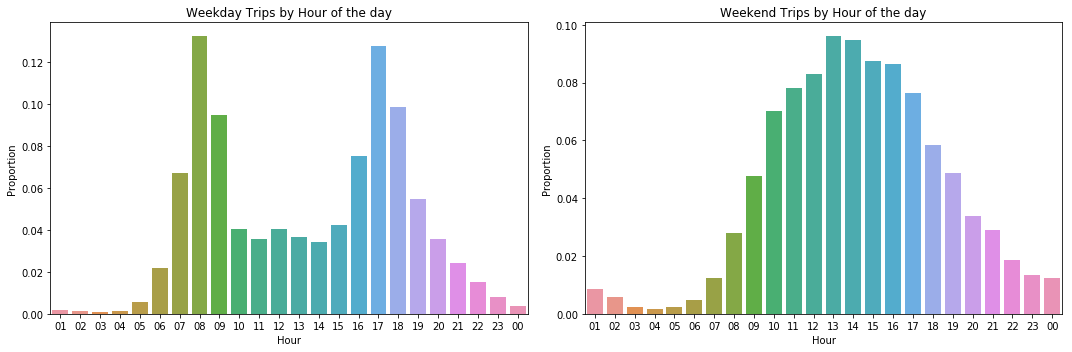

In [12]:
df['weekday'] = df['start_time'].dt.weekday
plt.figure(figsize=(15,5))

plt.subplot(121)
weekday = df.query('weekday not in (5,6)')
weekday_hours = weekday.start_hour.value_counts(normalize=True)
sns.barplot(x= weekday_hours.keys(), y= weekday_hours.values)

plt.title('Weekday Trips by Hour of the day')
plt.ylabel('Proportion')
plt.xlabel('Hour');

plt.subplot(122)
weekend = df.query('weekday in (5,6)')
weekend_hours = weekend.start_hour.value_counts(normalize=True)
sns.barplot(x= weekend_hours.keys(), y= weekend_hours.values)

plt.title('Weekend Trips by Hour of the day')
plt.ylabel('Proportion')
plt.xlabel('Hour');

plt.tight_layout()

## Relationship between the duration, user types, and the gender of the Riders
We are going to look at how these three variables relate to each other using a violin plot.

Customers (Casual riders) have only few minutes of ride, compared to the subscribers that have access to at least 45 minutes of ride. However, customers had longer duration of minutes compared to the subscribers whose duration was generally shorter.

Customers might want to maximise the opportunity they have to ride, and might be tourists taking leisure rides. This might be why the rides are longer than subscribers.

Evaluating the relationship between gender and ride duration, there seems to be no difference, as both genders perform as well as the other.

In [9]:
# define variables of interest, and create a new dataframe for this data 
bivar_variables = ['user_type', 'member_gender','duration_mins', 'member_age', 'weekday','start_hour']

df_bivar = df[bivar_variables]
df_bivar['user_type'] = df_bivar['user_type'].replace(['Subscriber'],0)
df_bivar['user_type'] = df_bivar['user_type'].replace(['Customer'],1)
df_bivar['member_gender'] = df_bivar['member_gender'].replace(['Male'],0)
df_bivar['member_gender'] = df_bivar['member_gender'].replace(['Female', 'Other'],1)
df_bivar['start_hour'] = df_bivar['start_hour'].astype(int)

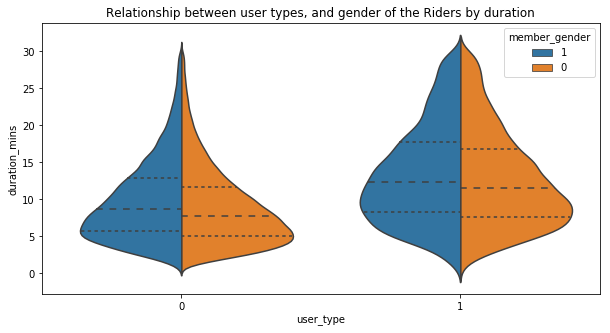

In [10]:
# Relationship between the duration, user types, and the gender of the Riders
df_bivar_dur = df_bivar.query('member_age <95 & duration_mins < 30')

plt.figure(figsize=[10,5])
sns.violinplot(data=df_bivar_dur, y='duration_mins', x='user_type', hue='member_gender', split=True, orient='v', inner='quartile',
              hue_order=[1,0]);
plt.title('Relationship between user types, and gender of the Riders by duration');

### Generate Slideshow
Once you're ready to generate your slideshow, use the `jupyter nbconvert` command to generate the HTML slide show.  

In [ ]:
# Use this command if you are running this file in local
!jupyter nbconvert Part_II_slide_deck_template.ipynb --to slides --post serve --no-input --no-prompt

[NbConvertApp] Converting notebook Part_II_slide_deck_template.ipynb to slides
[NbConvertApp] Writing 378107 bytes to Part_II_slide_deck_template.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Serving your slides at http://127.0.0.1:8000/Part_II_slide_deck_template.slides.html
Use Control-C to stop this server
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: x-www-browser: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: firefox: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: iceweasel: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: seamonkey: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: mozilla: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: epiphany: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: konqueror: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: chromium-browser: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: google-chrome: not found
/usr/bin/xdg-open: 778: /usr/bin/